In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from utils.elfnn import ELFNN

In [2]:
# instantiate ELFNN object
elf = ELFNN()

### Load and analyze training data

In [3]:
elf.load_data(sort=True, structure=True, additional=True, drop_duplicates=True)

Parse additional: 100%|██████████| 97/97 [00:00<00:00, 19302.91it/s]            


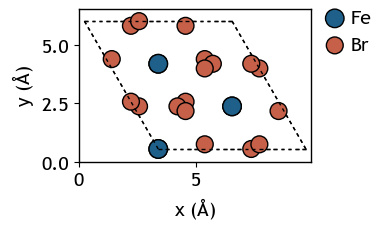

In [4]:
elf.plot_structure(elf.bm.iloc[0].structure);

In [5]:
elf.pca_fit(ev=0.9995)             # perform PCA on the ELF profiles

In [6]:
elf.get_distances(column='elf')    # compute distances from unlabeled examples to most similar labeled example

Compute EMD: 100%|██████████| 186387/186387 [00:15<00:00, 12071.35it/s]         


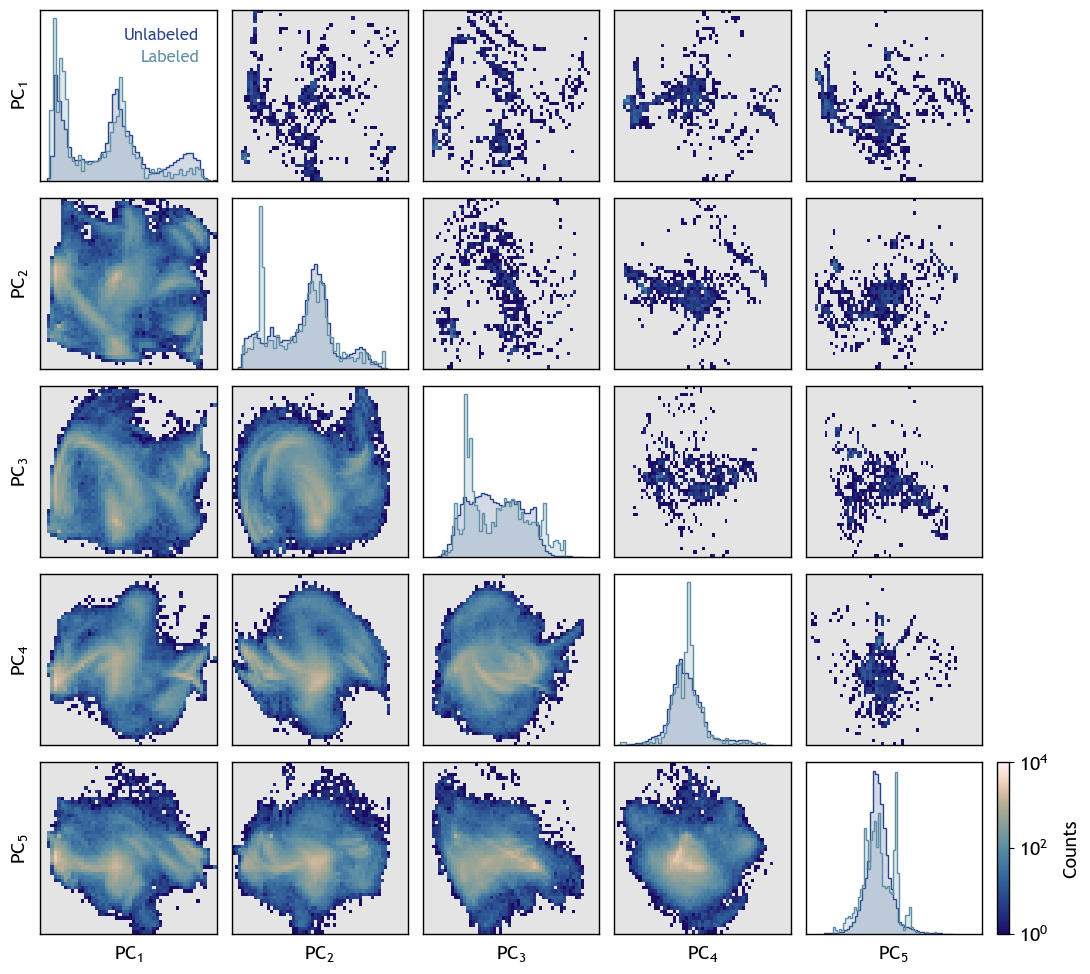

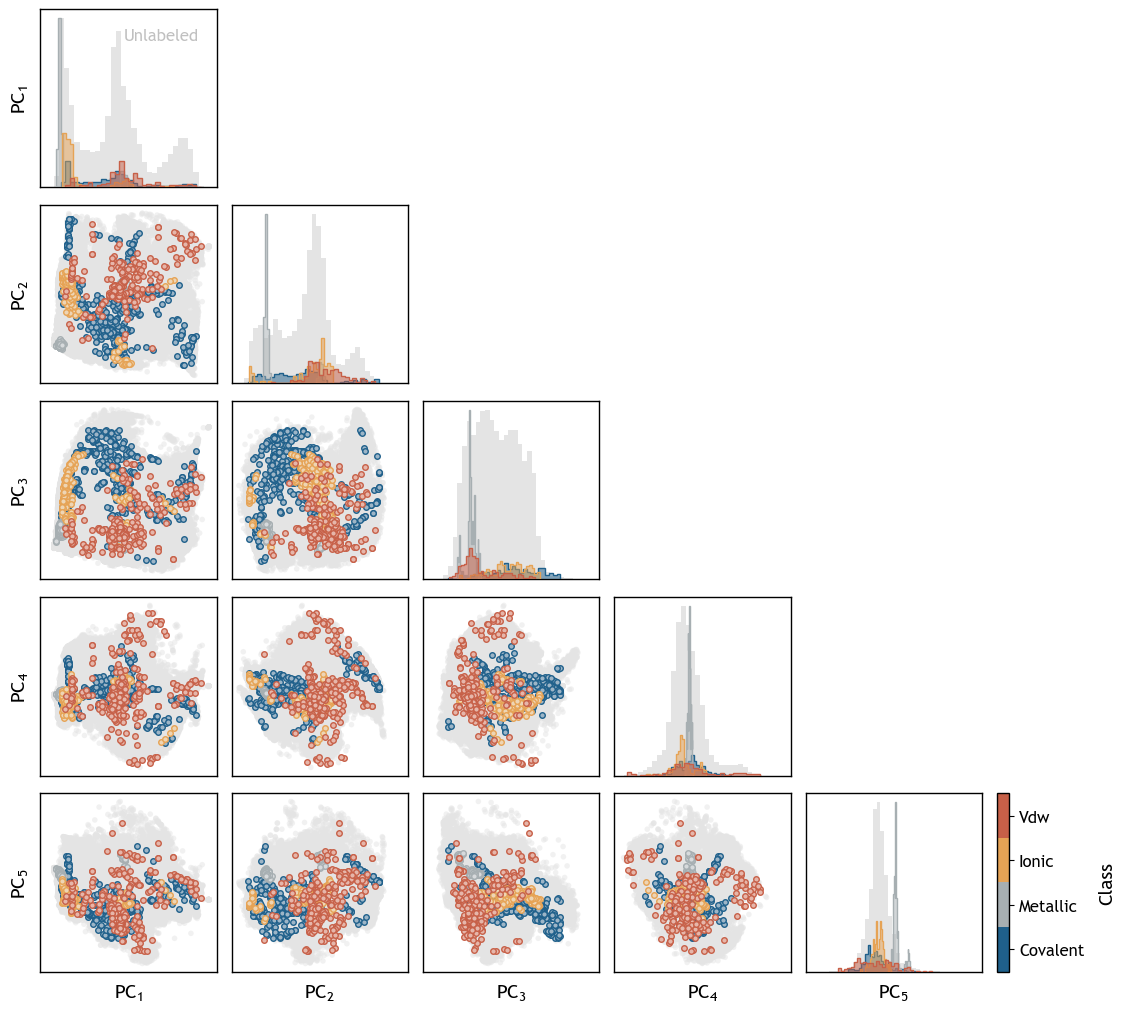

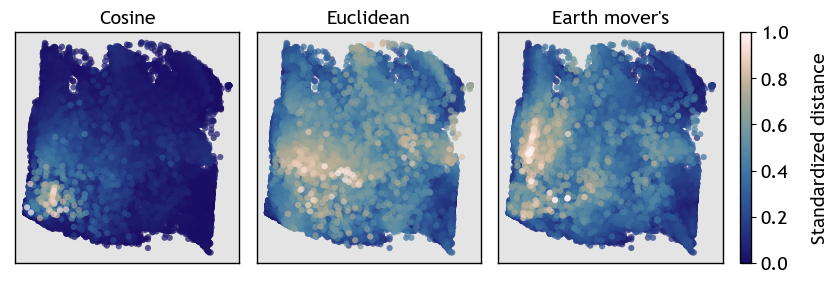

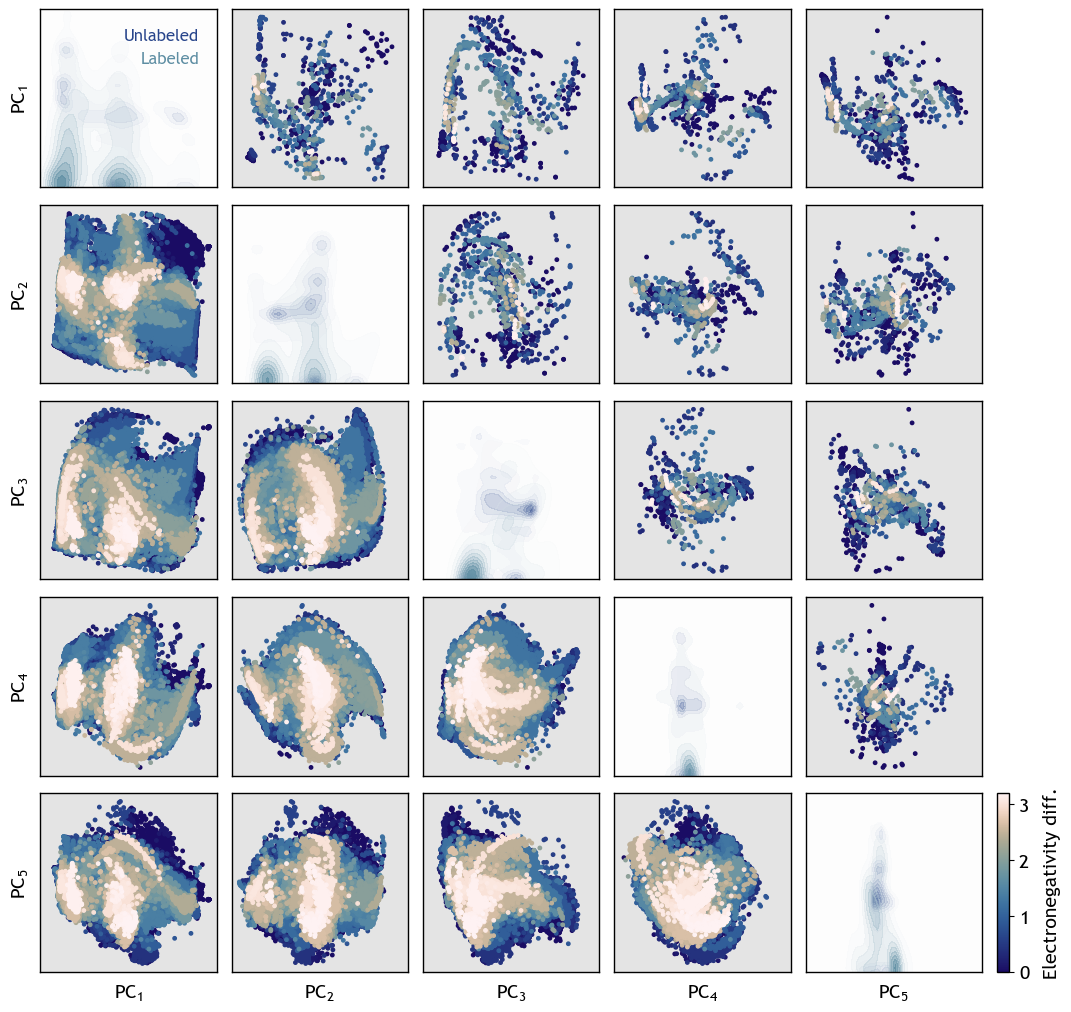

In [7]:
elf.plot_pca_distribution(orig=True)         # visualize distribution of examples in principal component space
elf.plot_pca_labels(orig=True)               # visualize distribution of labels in principal component space
elf.plot_pca_distances(orig=True)            # plot distance to most similar labeled example
elf.plot_pca_features('e_diff', orig=True);  # visualize distribution of features in principal component space

### Process data and train networks

In [49]:
# transform data
elf.pca_fit(ev=0.9995)                         # reduce dimensionality of ELF profiles
elf.prepare_inputs(inputs=['z', 'e_diff'])     # define input columns
elf.scaler_fit()                               # standardize input columns

In [50]:
# compute new label column
elf.bm['_label'] = elf.bond_to_float(elf.bm['label'].tolist())
elf.bm['_label'] = elf.bm['_label'].apply(lambda x: 2 if x >= 2 else x)

In [52]:
# train/test split
test_size = 0.2
elf.stratified_split(test_size, y='_label')    # train/test split

n_splits = 100
elf.kfold_split(n_splits, test_size)           # ensemble split

Class weights: [0.21330411 0.5260629  0.26063299]


In [45]:
# define and train models
model_path = 'models/stc_012523_srt_pca_en'
#threshold = 0.4
threshold = np.append(np.arange(0.3,0.9,0.1), 0.999)
elf.init_clf(alpha=0.01, hidden_layer_sizes=(10,),
             activation='relu', max_iter=1000, batch_size=32)                 # define classifier hyperparameters
elf.self_train_clf(threshold=threshold, max_iter=50, model_path=model_path)   # self-train classifier

100%|██████████| 3/3 [2:12:09<00:00, 2643.19s/it]                               


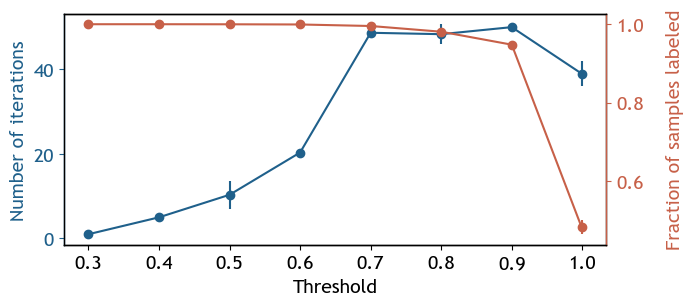

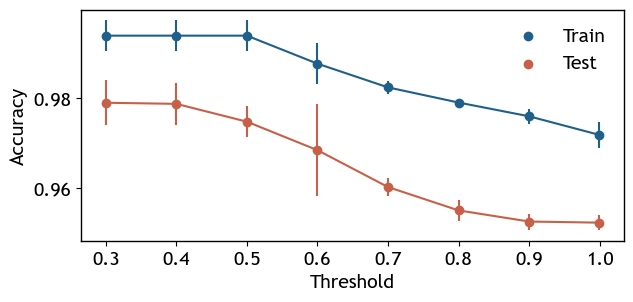

In [50]:
elf.plot_threshold_stats()

In [53]:
# define and train models
model_path = 'models/clf_012523_srt_pca_en'
elf.init_clf(alpha=0.01, hidden_layer_sizes=(10,),
             activation='relu', max_iter=1000, batch_size=32)    # define classifier hyperparameters
elf.train_clf(model_path=model_path)                             # train classifier

100%|██████████| 100/100 [01:09<00:00,  1.43it/s]                               


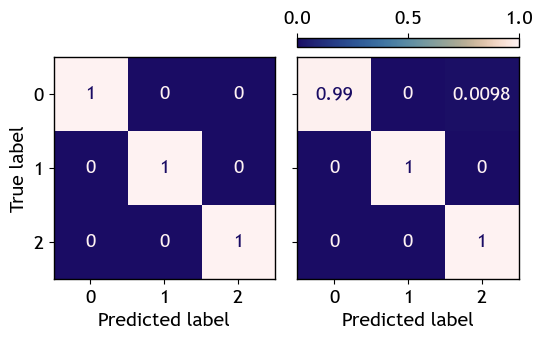

In [54]:
# evaluate trained models
model_path = 'models/clf_012523_srt_pca_en'
elf.load_model(model_path)
bm = elf.predict(elf.bm, threshold=0.8)

fig, ax = plt.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1)
cax = fig.add_axes([ax[1].get_position().x0, ax[1].get_position().y1 + 0.02, ax[1].get_position().width, 0.03])

ConfusionMatrixDisplay.from_predictions(bm.iloc[elf.idx_train]['y_class'], bm.iloc[elf.idx_train]['_label'],
                                        cmap=elf.cmap, normalize='true', colorbar=False, ax=ax[0])

g = ConfusionMatrixDisplay.from_predictions(bm.iloc[elf.idx_test]['y_class'], bm.iloc[elf.idx_test]['_label'],
                                            cmap=elf.cmap, normalize='true', colorbar=False, ax=ax[1])

cbar = plt.colorbar(g.im_, cax=cax, orientation='horizontal')
cbar.ax.xaxis.set_ticks_position('top') 

ax[1].set_ylabel('');

In [56]:
for t in threshold:
    bm = elf.predict(elf.bm, threshold=t)
    for i in bm.loc[bm['_label'] != bm['y_class']].formula.tolist():
        print(i, end=', ')
    print('')

Threshold: 0.3
HF_vdw, GaAs, InI, SnS_cov, SnS_cov, Ge2, Ge2, 
Threshold: 0.4
HF_vdw, GaAs, InI, SnS_cov, SnS_cov, Ge2, Ge2, 
Threshold: 0.5
HF_vdw, GaAs, InI, SnS_cov, SnS_cov, Ge2, Ge2, Ge2, 
Threshold: 0.6000000000000001
HF_vdw, HgS, GaAs, InI, SnS_cov, SnS_cov, Ge2, Ge2, Ge2, Ge2, AlCl3, 
Threshold: 0.7000000000000002
HF_vdw, HgS, MgS, InI, SnS_cov, SnS_cov, Ge2, Ge2, Ge2, Ge2, Ge2, Ge2, Ge2, Ge2, Ge2, AlCl3, 
Threshold: 0.8000000000000003
HF_vdw, HgS, CdS, MgS, MgS, InI, SnS_cov, SnS_cov, Ge2, Ge2, Ge2, Ge2, Ge2, Ge2, Ge2, Ge2, Ge2, AlCl3, 
Threshold: 0.9000000000000001
HgSe, HF_vdw, HgS, HgS, GaAs, CdS, CdS, MgS, MgS, MgS, SnS_cov, SnS_cov, Ge2, Ge2, Ge2, Ge2, Ge2, Ge2, Ge2, Ge2, Ge2, AlCl3, 
Threshold: 0.999
CdSe, HgSe, HgSe, HF_vdw, HgS, HgS, GaAs, CdS, CdS, MgS, MgS, MgS, MgS, MgS, MoSTe_cov, SnS_cov, SnS_cov, Ge2, Ge2, Ge2, Ge2, Ge2, Ge2, Ge2, Ge2, Ge2, AlCl3, 


### Predict on target data using trained networks

In [3]:
# load trained network
model_path = 'models/clf_011723_srt_pca_en'
elf.load_model(model_path)

In [ ]:
# load target examples
data = elf.load_data(dirname='data/labeled/', structure=True, additional=True)

In [14]:
# transform target data
data = elf.pca_transform(data)
data = elf.prepare_inputs(inputs=['z', 'e_diff'], data=data)
data = elf.scaler_transform(data)

In [18]:
# predict on target data
data = elf.predict(data, threshold=0)

In [15]:
# regroup data by material
data = elf.regroup(data, by=['id', 'formula', 'structure'], columns=['y_class', 'y_class_mean', 'y_class_std'])